In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
!pip install keras_cv -q

In [3]:
!pip install --upgrade tf-keras

In [4]:
!pip install --upgrade tensorflow-text

In [5]:
!pip install --upgrade tensorflow

In [6]:
!pip install --upgrade keras

In [7]:
!pip install segmentation_models

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [9]:
train_ds = load_voc(split="sbd_train")
eval_ds = load_voc(split="sbd_eval")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


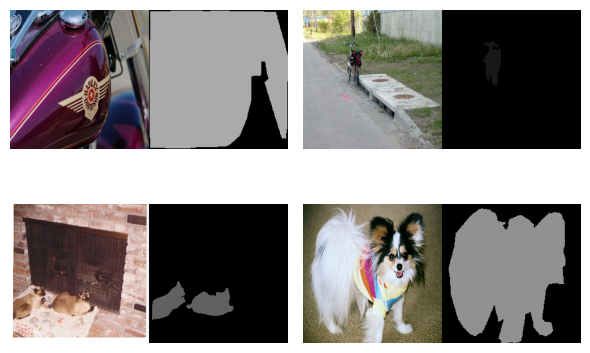

In [10]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [11]:
eval_ds = preprocess_tfds_inputs(eval_ds)

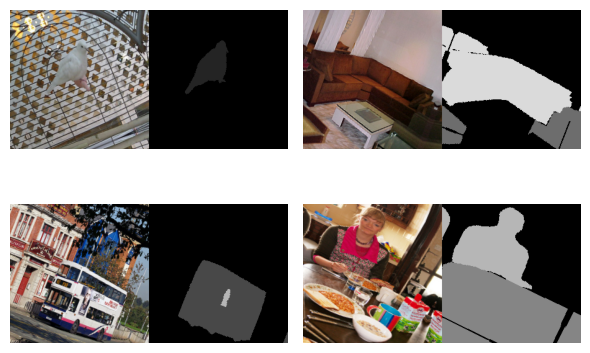

In [12]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def unet_model(input_size=(224,224, 3)):
    inputs = layers.Input(input_size)

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Expansive Path
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = layers.Conv2D(21, 1, activation='softmax')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


model = unet_model()



In [14]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [15]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [16]:
metrics = ['accuracy', jaccard_coef]
# Define callbacks
checkpoint = ModelCheckpoint("unet_model.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode='min')

# Compile the model with callbacks
model.compile(optimizer='adam', loss=total_loss, metrics=['accuracy', jaccard_coef])



In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 28, 28, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 14, 14, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,032,897 (118.38 MB)

 Trainable params: 31,032,897 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)

eval_ds = eval_ds.map(dict_to_tuple)



In [ ]:
model.fit(train_ds, validation_data=eval_ds, epochs=10, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/10
    265/Unknown 728s 3s/step - accuracy: 0.6780 - jaccard_coef: 0.5107 - loss: 1.0217

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.01886, saving model to unet_model.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - accuracy: 0.6780 - jaccard_coef: 0.5107 - loss: 1.0217 - val_accuracy: 0.6945 - val_jaccard_coef: 0.5337 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6849 - jaccard_coef: 0.5223 - loss: 1.0209
Epoch 2: val_loss improved from 1.01886 to 1.01883, saving model to unet_model.weights.h5
265/265 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.6849 - jaccard_coef: 0.5223 - loss: 1.0209 - val_accuracy: 0.6946 - val_jaccard_coef: 0.5335 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6843 - jaccard_coef: 0.5216 - loss: 1.0210
Epoch 3: val_loss did not improve from 1.01883
265/265 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.6843 - jaccard_coef: 0.5216 - loss: 1.0210 - val_accuracy: 0.6944 - val_jaccard_coef: 0.5333 - val_loss: 1.0189 - learni

In [27]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [28]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

None


In [30]:
flag = False
for l in model1.layers:
    if l.name == 'decoder_stage0_upsampling':
        flag = True
    l.trainable = flag

In [31]:
model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 5,790,373 (22.09 MB)

 Non-trainable params: 2,259,968 (8.62 MB)

In [32]:
model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32 )

Epoch 1/10
    265/Unknown 505s 2s/step - accuracy: 0.5099 - jaccard_coef: 0.2723 - loss: 0.9444

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.5103 - jaccard_coef: 0.2726 - loss: 0.9443 - val_accuracy: 0.2947 - val_jaccard_coef: 0.1370 - val_loss: 0.9844
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.6608 - jaccard_coef: 0.4297 - loss: 0.8803 - val_accuracy: 0.6237 - val_jaccard_coef: 0.4287 - val_loss: 0.8927
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.6448 - jaccard_coef: 0.4334 - loss: 0.8607 - val_accuracy: 0.6687 - val_jaccard_coef: 0.4750 - val_loss: 0.8587
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.6416 - jaccard_coef: 0.4452 - loss: 0.8435 - val_accuracy: 0.6543 - val_jaccard_coef: 0.4724 - val_loss: 0.8444
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.6501 - jaccard_coef: 0.4624 - loss: 0.8306 - val_accuracy: 0.6518 - val_jaccard_coef: 0.4654 - val_loss: 0.8448
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.6629 - jaccard_coef: 0.4761 - loss: 0.8174 - val_

In [33]:
#let all the layers be trained
# ensure all layers are trainable
for layer in model1.layers:
    layer.trainable = True

In [34]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [35]:
model1.compile(optim, total_loss, metrics=metrics)

In [36]:
model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

In [37]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32 )

Epoch 1/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.6554 - jaccard_coef: 0.4740 - loss: 0.8499 - val_accuracy: 0.6462 - val_jaccard_coef: 0.4622 - val_loss: 0.8033
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.7116 - jaccard_coef: 0.5359 - loss: 0.7602 - val_accuracy: 0.7067 - val_jaccard_coef: 0.5292 - val_loss: 0.7417
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.7370 - jaccard_coef: 0.5660 - loss: 0.7174 - val_accuracy: 0.7415 - val_jaccard_coef: 0.5714 - val_loss: 0.6978
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.7500 - jaccard_coef: 0.5822 - loss: 0.6989 - val_accuracy: 0.7631 - val_jaccard_coef: 0.5988 - val_loss: 0.6724
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.7579 - jaccard_coef: 0.5921 - loss: 0.6750 - val_accuracy: 0.7749 - val_jaccard_coef: 0.6145 - val_loss: 0.6475
